From arXiv:2204.06633 implement instrument response into signal detection.  

In [68]:
import numpy as np
import pdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.interpolate as interp
from scipy.constants import c
from lisatools.utils.constants import *
from few.waveform import GenerateEMRIWaveform, FastSchwarzschildEccentricFlux
from functools import partial
import copy
import lisaorbits
import lisaconstants


Create the Solar System's Barycenter (SSB) reference frame. SSB spherical cordinates ($\theta$, $\phi$) are based on the orthonormal basis ($\hat{e}_r$, $\hat{e}_\theta$, $\hat{e}_\phi$). Source localization is parameterized by the ecliptic latitude $\beta = \pi/2 - \theta$ and the ecliptic longitude $\lambda = \phi$. 

SSBReferenceFrame is initialized for a given $\beta$ and $\lambda$ creating the basis vectors for the SSB spherical coordinate system which is then used to define the propagation vector $\hat{k} = -\hat{e}_r$ and the polarization vectors $\hat{u} = -\hat{e}_\theta$ and $\hat{v} = -\hat{e}_\phi$ which create an orthonormal basis ($\hat{k}$, $\hat{u}$, $\hat{v}$). 

The antenna pattern functions $\xi_+$ and $\xi_-$ are defined in terms of the ($\hat{k}$, $\hat{u}$, $\hat{v}$) basis and the link unit vector $\hat{n}_{ij}$ and is taken from the lisaorbits package. The sum of the cross product of these functions with the corresponding components of the gw strain give the deformation induced on the link $ij$ where $ij$ indicates the arm starting at the $ith$ satellite and traveling to the $jth$ satellilte.

In [69]:
orbits = lisaorbits.KeplerianOrbits()

In [70]:
def make_galactic(orbits, T=3.156e6, N=210388):
    tm = np.linspace(0, T, num=N, endpoint=False)

    # spacecraft positions (km) - SC x T x XYZ
    pos = np.array([orbits.compute_position(orbits.t0 + tm, [sc]).reshape(len(tm),3)
                     for sc in orbits.SC]) / lisaconstants.SPEED_OF_LIGHT
    
    return tm, pos

In [71]:
3.156e6/210388 # T and N setting an observing frequency?

15.000855562104302

In [72]:
tm, pos = make_galactic(orbits)

In [73]:
class LinkUnitVector:
    def __init__(self):
        self.n_dict = {
            (1, 2): np.array([1, 1, 0]),
            (2, 1): np.array([-1, -1, 0]),
            (1, 3): np.array([1, 0, 1]),
            (3, 1): np.array([-1, 0, -1]),
            (2, 3): np.array([0, 1, 1]),
            (3, 2): np.array([0, -1, -1])
        }

    def __call__(self, i, j):
        return self.n_dict.get((i, j))

In [74]:
nhat = LinkUnitVector()

In [75]:
class SSBReferenceFrame:
    def __init__(self, beta, lam):
        # replace lam with lam
        self.beta = beta
        self.lam = lam

        self.er = np.array([np.cos(self.beta)*np.cos(self.lam), np.cos(self.beta)*np.sin(self.lam), np.sin(self.beta)])
        self.etheta = np.array([np.sin(self.beta)*np.cos(self.lam), np.sin(self.beta)*np.sin(self.lam), -np.cos(self.beta)])
        self.ephi = np.array([-np.sin(self.lam), np.cos(self.lam), 0])

        self.khat = -self.er
        self.uhat = -self.etheta
        self.vhat = -self.ephi

    def __call__(self):
        return self.er, self.etheta, self.ephi, self.khat, self.uhat, self.vhat

In [76]:
frame = SSBReferenceFrame(beta = 7, lam = 8)

In [77]:
er, etheta, ephi, khat, uhat, vhat = frame()

In [78]:
class AntennaPatternFunctions:
    def __init__(self, frame):
        self.frame = frame

    def __call__(self, i, j):
        er, etheta, ephi, khat, uhat, vhat = self.frame() # number of returns needs to equal number of objects or one tuple
        nhat = LinkUnitVector()
        
        xiplus = np.dot(uhat, nhat(i, j))**2 - np.dot(vhat, nhat(i, j))**2
        xicross = 2*np.dot(uhat, nhat(i, j))*np.dot(vhat, nhat(i, j))

        return xiplus, xicross

In [79]:
antennta_pattern = AntennaPatternFunctions(frame)

In [80]:
xiplus, xicross = antennta_pattern(1, 2)

Generate a waveform with the listed parameters. The result is of the form $h(t) = h_+(t) + ih_x(t)$. Separate the plus and cross components. 

Light emitted by spacecraft $j$ at $t_j$ reaches spacecraft $i$ at time $t_i$. Both position and time here are functions of the ecliptic longitude $\lambda$ which are approximated to first order by $t(\lambda) = t_j + \lambda/c$ and $x(\lambda) = x_j(t_j) + \lambda * \hat{n}_{ij}$ where $x_j(t_j)$ is the position of spacecraft 2 at the time of emission. 

Differentiating equation 13 with induced strain as a function of time yeilds the frequency shift $y_{ij}$ as light travels along link $ij$. Taking $x_i(t_i) = x_j(t_j) + L_{ij}\hat{n}_{ij}(t_j)$ and $t_i \approx t_j + L_{ij}/c$ and the fact that the spacecraft moves slowly compared to the propagation timescale allows for the assumption $x_j(t_j) \approx x_j(t_i)$ and $hat{n}_{ij}(t_j) \approx \hat{n}_{ij}(t_i)$ giving equation 16 and is the result of FrequencyShift. 

In [81]:
gen_wave = GenerateEMRIWaveform("FastSchwarzschildEccentricFlux")

# parameters
T = 0.1             # years (total length of waveform)
dt = 15.0           # seconds (space between points)
M = 1e6             # mass of the central black hole
a = 0.1             # spin of central black hole (ignored for Schwarzschild)
mu = 1e1            # mass of the compact object
p0 = 12.0           # initial semi-latus rectum
e0 = 0.2            # initial eccentricity
x0 = 1.0            # initial cosine of the inclination (ignored for Schwarzschild)
qK = 0.2            # polar spin angle in ellicptic coordinates
phiK = 0.2          # azimuthal viewing angle (azimuthal spin angle in ellicptic coordinates)
qS = 0.3            # polar sky angle (sky location polar angle in ellipctic coordinates)
phiS = 0.3          # azimuthal viewing angle (sky location azimuthal angle in ellipctic coordinates)
dist = 1.0          # Luminosity distance in Gpc
Phi_phi0 = 1.0      # initial phase for Phi_phi
Phi_theta0 = 2.0    # initial phase for Phi_theta
Phi_r0 = 3.0        # initial phase for Phi_r

h = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

obs_time = np.arange(0, T * 3.154e7 / dt, dt)
obs_length = T * 3.154e7 / dt

YRSID_SI = 31558149.763545603

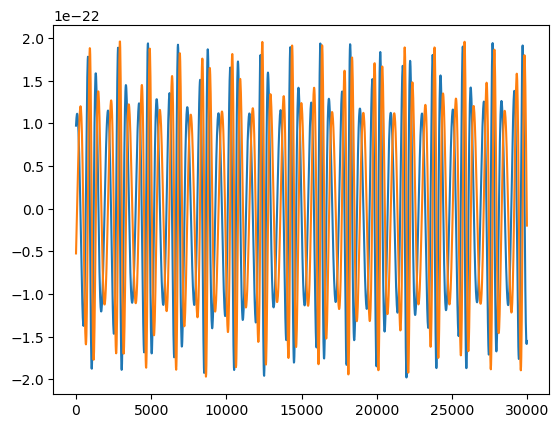

In [82]:
plt.plot(np.arange(2000) * dt, h.real[:2000])
plt.plot(np.arange(2000) * dt, h.imag[:2000])
plt.show()

In [83]:
const_time_genwave = partial(gen_wave, T=0.1, dt=15.0)

In [84]:
hplus = np.array(h.real)
hcross = np.array(h.imag)

In [85]:
class InducedDeformation:
    def __init__(self, hplus, hcross, frame, dt):
        self.hplus = hplus
        self.hcross = hcross
        self.antenna_pattern = AntennaPatternFunctions(frame)
        self.dt = dt

    def __call__(self, t, i, j):
        xiplus, xicross = self.antenna_pattern(i, j)
        
        t_values = np.arange(len(hplus))*self.dt # accounts for IF signal merges within T
        
        hplus_interp = interp.interp1d(t_values, self.hplus, bounds_error=False, fill_value=0.0)
        hcross_interp = interp.interp1d(t_values, self.hcross, bounds_error=False, fill_value=0.0)

        cap_h = hplus_interp(t) * xiplus + hcross_interp(t) * xicross
        
        return cap_h 

In [86]:
cap_h = InducedDeformation(hplus, hcross, frame, dt)

In [87]:
proplen = 2.5e9 # constant arm length in m divide by c to get seconds

In [88]:
class SpacecraftPosition:
    def __init__(self, pos):
        self.pos = pos

    def __call__(self, u):
        # specify desired spacecraft with u and desired x,y,z motion with v (or do we need xyz?)
        return self.pos[u, :, :]

In [89]:
positions = SpacecraftPosition(pos)

In [90]:
class FrequencyShift:
    def __init__(self, hplus, hcross, frame, dt):
        '''We want to define frequency shift so that we can call it by specifying which arm we
        traveled down and what spacecraft we are consideing. So i,j will be used like in nhat
        thereby specifying the arm and u,v will be used like in position specifying the spacecraft.
        But we still want freq shift to be double indexed corresponding to the i,j indices.'''
        self.hplus = hplus
        self.hcross = hcross
        self.frame = frame
        self.dt = dt
        self.induced_deformation = InducedDeformation(hplus, hcross, frame, dt)
        

    def __call__(self, t, i, j, u, v):
        # any object needs to be passed in but functions can be called directly
        # set up khat, antenna pattern functions, and induced deformation
        cap_h = self.induced_deformation
        er, etheta, ephi, khat, uhat, vhat = self.frame()
        positionu = positions(u)
        positionv = positions(v)

        t_values = np.arange(len(hplus))*self.dt

        positionu_interp = [interp.interp1d(t_values, positionu[:, k], bounds_error=False, fill_value=0.0)(t) for k in range(3)]
        positionv_interp = [interp.interp1d(t_values, positionv[:, k], bounds_error=False, fill_value=0.0)(t) for k in range(3)]

        positionu_interp = np.array(positionu_interp)
        positionv_interp = np.array(positionv_interp)

        t0_interp = t - proplen / c - (np.dot(khat, positionv_interp)) /c
        t00_interp = t - (np.dot(khat, positionu_interp)) / c

        cap_h0 = cap_h(t0_interp, i, j)
        cap_h00 = cap_h(t00_interp, i, j)
        
        
        y_ij = 1 / (2 * (1 - np.dot(khat, nhat(i,j)))) * (cap_h0 - cap_h00)

        return y_ij

In [91]:
y_ij = FrequencyShift(hplus, hcross, frame, dt)

In [92]:
y_ij(0, 1, 2, 0, 1)

0.0

In [93]:
interp_time = np.arange(0.0, T * YRSID_SI, dt) 

In [94]:
y_ij(interp_time, 1, 2, 0, 1)

array([ 0.00000000e+00,  3.04088282e-24,  2.96614519e-24, ...,
        3.57422202e-24,  3.51364956e-24, -6.10888733e-24])

With the frequency shift we can now construct the appropriate TDI combinations which are given by linear combinations of time-shifted measurements. In the equal arm approximation, an uncorrelated and exactly orthogonal set of TDI variables (A, E, T). This approximation comes at the cost of known correlation between arms as the just as well known arm breathing. We can relax this approximation later. These channels are given by

$A = \frac{1}{\sqrt{2}}(Z - X)$,
$E = \frac{1}{\sqrt{6}}(X - 2Y + Z)$,
$T = \frac{1}{\sqrt{3}}(X + Y + Z)$

where X, Y, Z are obtained by cycling indices (see DOI 10.1088/0264-9381/29/12/124015). What each corresponds to is not exactly clear.  Use first generation Michelson combinations (chosen here simply because they are easier - will need a source discussing their differences) to define X, Y, Z (equation 17).

$X_1 = y_{13} + D_{13}y_{31} + D_{131}y_{12} + D_{1312}y_{21} - [y_{12} + D_{12}y_{21} + D_{121}y_{13} + D_{1213}y_{31}]$.

$Y_1 = y_{21} + D_{21}y_{12} + D_{212}y_{23} + D_{2123}y_{32} - [y_{23} + D_{23}y_{32} + D_{232}y_{21} + D_{2321}y_{12}]$.

$Z_1 = y_{32} + D_{32}y_{23} + D_{323}y_{31} + D_{3231}y_{13} - [y_{31} + D_{31}y_{13} + D_{313}y_{32} + D_{3132}y_{23}]$.

$D_{ij}$ is the delay operator defined by equation 19. Due to the slow evolution of light travel times, chained delays can be computed using sums of delays (equation 20)

In [95]:
def delay_operator(func, t, d, *args, **kwargs):
    '''pass into the function the frequency shift we want delayed, the time value at which the
    delay occurs and the number of indices minus 1 (see eq 20).
    Make sure that the t passed here is the same one used to call the particular freq shift.'''
    tdelay = t - proplen / c * d
    args = list(args) # convert the arguments of freq shit to a list. set 't' = 'tdelay.' convert back to list
    args[0] = tdelay
    args = tuple(args)
    return func(*args, **kwargs)

In [96]:
delay_operator(y_ij, 9.5, 1, 9.5, 1, 2, 0, 1)

9.304085575886645e-24

In [97]:
class DelayOperator:
    '''Delay operator class. Here I think we could initialize the class with n being the number
    of indices the operator has. This works in the equal arm assumption along with the assumption
    that L_ij(t) = L i.e. we do not account for any kind of equal breathing if that is a thing.
    So in the case of the first generation Michelson Combinations we would need to instantiate
    three separate delay operators.
    
    OR
    
    instantiate with frequency shift. So define all of the necessary y_ij and 
    create many instances of the class corresponding to each one needed.'''
    
    def __init__(self, hplus, hcross, frame, dt):
        self.freqshift = FrequencyShift(hplus, hcross, frame, dt)

    def __call__(self, t, i, j, u, v, n):
        tdelay = t - proplen / c * (n - 1)
        y_ijdelay = self.freqshift(tdelay, i, j, u, v)
        
        return y_ijdelay

In [98]:
cap_d = DelayOperator(hplus, hcross, frame, dt)

In [99]:
cap_d(interp_time, 1, 2, 0, 1, 1)

array([ 0.00000000e+00,  3.04088282e-24,  2.96614519e-24, ...,
        3.57422202e-24,  3.51364956e-24, -6.10888733e-24])

In [100]:
class MichelsonCombinationGen1:
    def __init__(self, hplus, hcross, frame, dt):
        self.freqshift = FrequencyShift(hplus, hcross, frame, dt)
        self.delay = DelayOperator(hplus, hcross, frame, dt)
    
    def __call__(self, t):
        y_ij = self.freqshift
        y_ijdelay = self.delay
        
        X_1 = y_ij(t, 1, 3, 0, 2) + y_ijdelay(t, 3, 1, 2, 0, 2) + y_ijdelay(t, 1, 2, 0, 1, 3) 
        + y_ijdelay(t, 2, 1, 1, 0, 4) - (y_ij(t, 1, 2, 0, 1) + y_ijdelay(t, 2, 1, 1, 0, 2)
                                         + y_ijdelay(t, 1, 3, 0, 2, 3)
                                         + y_ijdelay(t, 3, 1, 2, 0, 4))
        
        Y_1 = y_ij(t, 2, 1, 1, 0) + y_ijdelay(t, 1, 2, 0, 1, 2) + y_ijdelay(t, 2, 3, 1, 2, 3)
        + y_ijdelay(t, 3, 2, 2, 1, 4) - (y_ij(t, 2, 3, 1, 2) + y_ijdelay(t, 3, 2, 2, 1, 2)
                                         + y_ijdelay(t, 2, 1, 1, 0, 3)
                                         + y_ijdelay(t, 1, 2, 0, 1, 4))
        
        Z_1 = y_ij(t, 3, 2, 2, 1) + y_ijdelay(t, 2, 3, 1, 2, 2) + y_ijdelay(t, 3, 1, 2, 0, 3)
        + y_ijdelay(t, 1, 3, 0, 2, 4) - (y_ij(t, 3, 1, 2, 0) + y_ijdelay(t, 1, 3, 0, 2, 2)
                                         + y_ijdelay(t, 3, 2, 2, 1, 3)
                                         + y_ijdelay(t, 2, 3, 1, 2, 4))
        
        A_1 = 1 / np.sqrt(2) * (Z_1 - X_1)
        E_1 = 1 / np.sqrt(6) * (X_1 - 2 * Y_1 + Z_1)
        T_1 = 1 / np.sqrt(3) * (X_1 + Y_1 + Z_1)

        return X_1, Y_1, Z_1, A_1, E_1, T_1


In [101]:
uncorrelated_tdi_gen1 = MichelsonCombinationGen1(hplus, hcross, frame, dt)

In [102]:
X_1, Y_1, Z_1, A_1, E_1, T_1 = uncorrelated_tdi_gen1(interp_time)

In [103]:
print(A_1, E_1)

[ 0.00000000e+00 -8.04426085e-23  5.16041066e-25 ...  1.53282057e-26
  1.49557919e-25  2.97632093e-23] [ 0.00000000e+00  2.66118430e-23 -2.15400223e-23 ... -2.24712234e-23
 -2.31248036e-23 -2.78284435e-24]


The Second Generation Michelson combinations are

$X_2 = X_1 + D_{13121}y_{12} + D_{131212}y_{21} + D_{1312121}y_{13} + D_{13121213}y_{31} - (D_{12131}y_{13} + D_{121313}y_{31} + D_{1213131}y_{12} + D_{12131212}y_{21})$

$Y_2 = Y_1 + D_{21232}y_{23} + D_{212323}y_{32} + D_{2123232}y_{21} + D_{21232321}y_{12} - (D_{23212}y_{21} + D_{232121}y_{12} + D_{2321212}y_{23} + D_{23212123}y_{32})$

$Z_2 = Z_1 + D_{32313}y_{13} + D_{3233131}y_{13} + D_{3231313}y_{21} + D_{32313132}y_{23} - (D_{31323}y_{23} + D_{313232}y_{23} + D_{3132323}y_{31} + D_{31323231}y_{13})$

In [104]:
class MichelsonCombinationGen2:
    def __init__(self, hplus, hcross, frame, dt):
        self.freqshift = FrequencyShift(hplus, hcross, frame, dt)
        self.delay = DelayOperator(hplus, hcross, frame, dt)
        self.uncorrelated_tdi_gen1 = MichelsonCombinationGen1(hplus, hcross, frame, dt)
    
    def __call__(self, t):
        y_ij = self.freqshift
        y_ijdelay = self.delay
        X_1, Y_1, Z_1, A_1, E_1, T_1 = self.uncorrelated_tdi_gen1(t)
        
        X_2 = X_1 + y_ijdelay(t, 1, 2, 0, 1, 5) + y_ijdelay(t, 2, 1, 1, 0, 6) 
        + y_ijdelay(t, 1, 3, 0, 2, 7) + y_ijdelay(t, 3, 1, 2, 0, 8) - (y_ijdelay(t, 1, 3, 0, 2, 5)
                                                        + y_ijdelay(t, 3, 1, 2, 0, 6)
                                                        + y_ijdelay(t, 2, 1, 0, 1, 7)
                                                        + y_ijdelay(t, 2, 1, 1, 0, 8))
        
        Y_2 = Y_1 + y_ijdelay(t, 2, 3, 1, 2, 5) + y_ijdelay(t, 3, 2, 2, 1, 6) 
        + y_ijdelay(t, 2, 1, 1, 0, 7) + y_ijdelay(t, 1, 2, 0, 1, 8) - (y_ijdelay(t, 2, 1, 1, 0, 5)
                                                        + y_ijdelay(t, 1, 2, 0, 1, 6)
                                                        + y_ijdelay(t, 2, 3, 1, 2, 7)
                                                        + y_ijdelay(t, 3, 2, 2, 1, 8))
        
        Z_2 = Z_1 + y_ijdelay(t, 3, 1, 2, 0, 5) + y_ijdelay(t, 1, 3, 0, 2, 6) 
        + y_ijdelay(t, 3, 2, 2, 1, 7) + y_ijdelay(t, 2, 3, 1, 2, 8) - (y_ijdelay(t, 3, 2, 2, 1, 5)
                                                        + y_ijdelay(t, 2, 3, 1, 2, 6)
                                                        + y_ijdelay(t, 3, 1, 2, 0, 7)
                                                        + y_ijdelay(t, 1, 3, 0, 2, 8))
        
        A_2 = 1 / np.sqrt(2) * (Z_2 - X_2)
        E_2 = 1 / np.sqrt(6) * (X_2 - 2 * Y_2 + Z_2)
        T_2 = 1 / np.sqrt(3) * (X_2 + Y_2 + Z_2)

        return X_2, Y_2, Z_2, A_2, E_2, T_2

In [105]:
uncorrelated_tdi_gen2 = MichelsonCombinationGen2(hplus, hcross, frame, dt)

In [106]:
X_2, Y_2, Z_2, A_2, E_2, T_2 = uncorrelated_tdi_gen2(interp_time)

In [107]:
print(A_2, E_2)

[ 0.00000000e+00 -8.04426085e-23  5.16041066e-25 ... -1.98048523e-23
 -2.09532251e-23  7.68095356e-24] [ 0.00000000e+00  2.66118430e-23 -2.15400223e-23 ... -1.80643080e-23
 -1.92844386e-23  4.70262100e-25]


In [108]:
from lisatools.sources.emri import EMRITDIWaveform

In [109]:
emri_lisa = EMRITDIWaveform(T = T, dt = dt, response_kwargs=dict(tdi = '2nd generation', tdi_chan="AET"))

In [110]:
AET = emri_lisa(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
)

In [111]:
print(AET)

[array([4.45557728e-24, 4.42357899e-24, 4.31669174e-24, ...,
       2.62358796e-24, 2.27938831e-24, 1.88968267e-24]), array([ 3.69349663e-24,  3.11674187e-24,  2.53168766e-24, ...,
       -1.65896004e-24, -1.85921084e-24, -2.04930968e-24]), array([5.77337895e-25, 7.69648504e-25, 9.26112951e-25, ...,
       7.94828863e-25, 9.30305708e-25, 1.06627850e-24])]


In [112]:
print(len(AET))

3


In [113]:
fewA = AET[0]
fewE = AET[1]
fewT = AET[2]

In [114]:
print(A_2)
print(fewA)

[ 0.00000000e+00 -8.04426085e-23  5.16041066e-25 ... -1.98048523e-23
 -2.09532251e-23  7.68095356e-24]
[4.45557728e-24 4.42357899e-24 4.31669174e-24 ... 2.62358796e-24
 2.27938831e-24 1.88968267e-24]


Text(0, 0.5, 'E Channel')

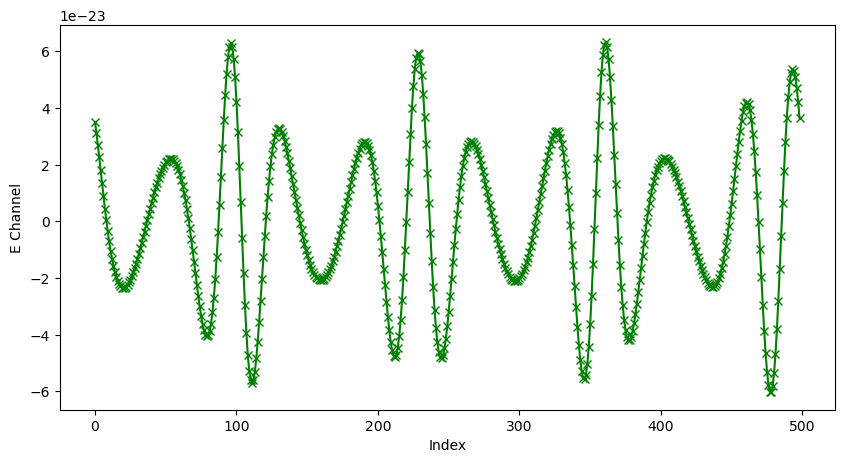

In [115]:
plt.figure(figsize = (10, 5))
# plt.plot(A_2[2001:2500], label='My A Channel', marker='o')
plt.plot(E_2[2001:2500], label='My E Channel', marker='x', color='green')
# plt.plot(T_2[2001:2500], label='My T Channel', marker='o', color='red')
# plt.plot(8.0*fewA[:500], label='few A Channel', marker='x')

plt.xlabel('Index')
plt.ylabel('E Channel')
# plt.legend(loc='lower right')


# plt.savefig('TDI_EchanLISASprint2025.png', dpi=300, bbox_inches='tight', facecolor='white')